In [40]:
import numpy as np
import pandas as pd
import random
import mir_utils as miru
import sounddevice as sd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from ast import literal_eval
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
#free style version in openset CNN at bottom
def fitSVM(encoding_path,dvn=False):
    
    if dvn:
        label_groups="label" #do drum vs not drum
    else:
        label_groups="drum_type" #do drum vs drum vs notdrum
        
    testFraction=0.2
    #load same data as t-SNE but train SVM with it    

    df=pd.read_csv(encoding_path)
    df=df.loc[df["drum_type"].isin(["clap","hat","kick","snare","synth_noise"])]  
#     print(df.groupby([label_groups]).agg("count")["path"])#sample counts


    #preperocessing
    le = preprocessing.LabelEncoder()
    le.fit(df[label_groups])
    le.transform(df[label_groups])
    df[label_groups]=le.transform(df[label_groups])
    y_counts=df.groupby([label_groups]).agg("count")["path"] #for weights


    #calculating weights
    wdict=y_counts.to_dict()
    total = sum(wdict.values(), 0.0)
    class_weights = {k: (total-v) / total for k, v in wdict.items()}
    y=df[label_groups]

    df["feats"]=df["feats"].apply(literal_eval)
    #df[feats] is an array of lists, needs conversion to ndArray
    X=np.array([np.array(x) for x in df["feats"].to_numpy()])
    wdict=y_counts.to_dict()
    total = sum(wdict.values(), 0.0)
    class_weights = {k: (total-v) / total for k, v in wdict.items()}


    classifier = make_pipeline(StandardScaler(), SVC(gamma='auto',class_weight=class_weights))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testFraction, random_state=42,)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    print(cross_val_score(classifier, X, y, cv=cv))
    classifier.fit(X_train, y_train,)
    y_pred = classifier.predict(X_test)


    return classifier, X_train, X_test, y_train, y_test,y_pred,le,X,y,class_weights,

p1="csvs/radarfree_best_emb.csv"
p2="csvs/radarfree_best_embenv.csv"
classifier, X1_train, X1_test, y1_train, y1_test,y1_pred,le1,X1,y1,class_weights  = fitSVM(p1)
print(confusion_matrix(y_test,y_pred))
print(classification_report(le1.inverse_transform(y_test),le1.inverse_transform(y_pred)))

classifier, X2_train, X2_test, y2_train, y2_test,y2_pred,le2,X2,y2,_  = fitSVM(p2)
print(confusion_matrix(y_test,y_pred))
print(classification_report(le2.inverse_transform(y_test),le2.inverse_transform(y_pred)))


[0.89029768 0.90187431 0.90187431 0.89801544 0.89636163]
[[ 47  11   1  10   3]
 [  5 250   1  13   4]
 [  1   0 253  18   1]
 [ 11  17  15 162   1]
 [  2   1   1   4 377]]
              precision    recall  f1-score   support

        clap       0.71      0.65      0.68        72
         hat       0.90      0.92      0.91       273
        kick       0.93      0.93      0.93       273
       snare       0.78      0.79      0.78       206
 synth_noise       0.98      0.98      0.98       385

    accuracy                           0.90      1209
   macro avg       0.86      0.85      0.86      1209
weighted avg       0.90      0.90      0.90      1209

[0.90132304 0.90352811 0.91014333 0.90187431 0.90628445]
[[ 47  11   1  10   3]
 [  5 250   1  13   4]
 [  1   0 253  18   1]
 [ 11  17  15 162   1]
 [  2   1   1   4 377]]
              precision    recall  f1-score   support

        clap       0.71      0.65      0.68        72
         hat       0.90      0.92      0.91       273
  

In [ ]:
#confusion cell
from yellowbrick.classifier import ClassificationReport,ConfusionMatrix

visualizer = ClassificationReport(classifier,classes=le.classes_, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(classifier, classes=le.classes_)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.

cm.score(X_test, y_test)

# How did we do?
cm.show()


In [ ]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

models = [
    SVC(gamma=0.001,C= 100,kernel='rbf',class_weight=class_weights), LinearSVC(C=10,class_weight=class_weights), 
    KNeighborsClassifier(n_neighbors=30,),
    RandomForestClassifier(n_estimators=300,class_weight=class_weights), ExtraTreesClassifier(n_estimators=1100,class_weight=class_weights),
]
# models = [
#     SVC(gamma=0.0001,C= 1000,kernel='rbf',class_weight=class_weights), LinearSVC(C=10,class_weight=class_weights), 
#     KNeighborsClassifier(n_neighbors=5,),
#     RandomForestClassifier(n_estimators=400,class_weight=class_weights), ExtraTreesClassifier(n_estimators=1000,class_weight=class_weights)]#dvn
  

def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
#         ('one_hot_encoder', OneHotEncoder()),
#         ('class_weight',class_weights),
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X_train, y_train, **kwargs)
    expected  = y_test
    predicted = model.predict(X_test)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average="weighted")))

for model in models:
    score_model(X, y, model,)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    print(cross_val_score(model, X, y, cv=cv))

In [23]:
#tuning cell
from sklearn.model_selection import GridSearchCV

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
# tuned_parameters = [{
#                      'n_neighbors': [2,5,10,20,30]},
#                     ]
tuned_parameters = [{
                     'n_estimators': [1100,1300,800,400,300]},
                    ]
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000,1500,2000,]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


scores = ['f1','jaccard']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
         RandomForestClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train,)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()



# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_estimators': 400}

Grid scores on development set:

0.982 (+/-0.008) for {'n_estimators': 1100}
0.981 (+/-0.007) for {'n_estimators': 1300}
0.981 (+/-0.006) for {'n_estimators': 800}
0.983 (+/-0.006) for {'n_estimators': 400}
0.980 (+/-0.008) for {'n_estimators': 300}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2020
           1       0.98      0.97      0.98      1003

    accuracy                           0.99      3023
   macro avg       0.99      0.98      0.98      3023
weighted avg       0.99      0.99      0.99      3023


# Tuning hyper-parameters for jaccard

Best parameters set found on development set:

{'n_estimators': 1300}

Grid scores on development set:

0.962 (+/-0.014) for {'n_estimators': 

In [90]:
import plotly.graph_objects as go
import plotly
import plotly.express as px
from kaleido.scopes.plotly import PlotlyScope
colors1=plotly.colors.sequential.Tealgrn[2:]
colors2=plotly.colors.sequential.Tealgrn_r[2:]
scope = PlotlyScope()
fig = go.Figure()

cv_num=2
df=pd.DataFrame(columns=["model","feat_type","y"])

for i,model in enumerate(models):
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0) # for quick test
    name=type(model).__name__.split("Class")[0]
    for y in cross_val_score(model, X2, y2, cv=cv):
        df.loc[len(df)]=[name,"Embedding+Envelope",y]   
    for y in cross_val_score(model, X1, y1, cv=cv):
        df.loc[len(df)]=[name,"Embedding Only",y] 




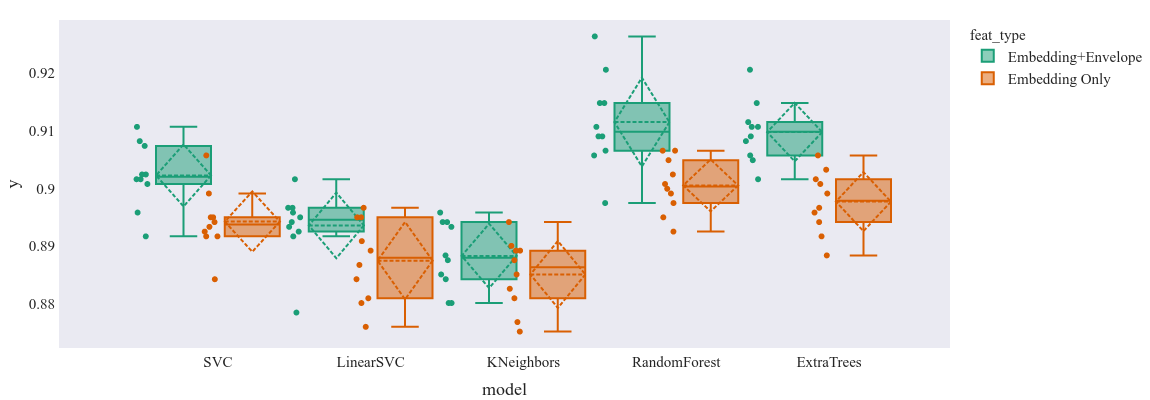

In [125]:
fig = px.box(df, x="model", y="y", color="feat_type",
             color_discrete_sequence=plotly.express.colors.qualitative.Dark2,
             title="Box plot of total bill",
            )
fig.update_layout(
#     showlegend=False,
    
    autosize=False,title=None, 
    template="seaborn",
    width=1100,height=400,
    font_family="Times New Roman",
    font_size=15,
    title_font_family="Times New Roman",
    title_font_size=30,
    boxmode='group',
    margin=dict(l=0, t=20,r=5, b=5),       
    boxgap=0.1,boxgroupgap=0.2, 
    )
fig.update_traces(
        boxmean="sd", # represent mean. (sd shows standarddev)
        boxpoints='all', 
)
fig.update_xaxes(showgrid=False,zeroline=False,ticks='',)
fig.update_yaxes(showgrid=False,zeroline=False,)

fig.show()
# df.to_csv("csvs/mme_comparisons_mme.csv")
with open("../plots/mme_comparisons_mme.pdf", "wb") as f:
    f.write(scope.transform(fig, format="pdf", width=800,height=400,))

In [37]:
def fitModel(model,encoding_path,dvn=False):
    
    if dvn:
        label_groups="label" #do drum vs not drum
    else:
        label_groups="drum_type" #do drum vs drum vs notdrum
        
    testFraction=0.2
    #load same data as t-SNE but train SVM with it    

    df=pd.read_csv(encoding_path)
    df=df.loc[df["drum_type"].isin(["clap","hat","kick","snare","synth_noise"])]  
#     print(df.groupby([label_groups]).agg("count")["path"])#sample counts


    #preperocessing
    le = preprocessing.LabelEncoder()
    le.fit(df[label_groups])
    le.transform(df[label_groups])
    df[label_groups]=le.transform(df[label_groups])
    y_counts=df.groupby([label_groups]).agg("count")["path"] #for weights


    #calculating weights
    wdict=y_counts.to_dict()
    total = sum(wdict.values(), 0.0)
    class_weights = {k: (total-v) / total for k, v in wdict.items()}
    y=df[label_groups]

    df["feats"]=df["feats"].apply(literal_eval)
    #df[feats] is an array of lists, needs conversion to ndArray
    X=np.array([np.array(x) for x in df["feats"].to_numpy()])
    wdict=y_counts.to_dict()
    total = sum(wdict.values(), 0.0)
    class_weights = {k: (total-v) / total for k, v in wdict.items()}


    classifier = make_pipeline(StandardScaler(), model)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testFraction, random_state=42,)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    print(cross_val_score(classifier, X, y, cv=cv))
    classifier.fit(X_train, y_train,)
    y_pred = classifier.predict(X_test)


    return classifier, X_train, X_test, y_train, y_test,y_pred,le,X,y,class_weights,

p1="csvs/radarfree_best_emb.csv"
p2="csvs/radarfree_best_embenv.csv"
model = m 
classifier, X_train, X_test, y_train, y_test,y_pred,le1,X,y,class_weights  = fitModel(ExtraTreesClassifier(n_estimators=1100,class_weight=class_weights),p1)
print(confusion_matrix(y_test,y_pred))
print(classification_report(le1.inverse_transform(y_test),le1.inverse_transform(y_pred)))

classifier, X_train, X_test, y_train, y_test,y_pred,le2,X,y,_  = fitModel(ExtraTreesClassifier(n_estimators=1100,class_weight=class_weights),p2)
print(confusion_matrix(y_test,y_pred))
print(classification_report(le2.inverse_transform(y_test),le2.inverse_transform(y_pred)))

[0.89581036 0.8985667  0.90352811 0.90187431 0.90352811]
[[ 50  10   0   7   5]
 [  5 247   2  12   7]
 [  0   0 253  16   4]
 [ 15  15  18 155   3]
 [  5   4   3   2 371]]
              precision    recall  f1-score   support

        clap       0.67      0.69      0.68        72
         hat       0.89      0.90      0.90       273
        kick       0.92      0.93      0.92       273
       snare       0.81      0.75      0.78       206
 synth_noise       0.95      0.96      0.96       385

    accuracy                           0.89      1209
   macro avg       0.85      0.85      0.85      1209
weighted avg       0.89      0.89      0.89      1209

[0.90628445 0.90959206 0.9123484  0.9106946  0.91014333]
[[ 47  11   1  10   3]
 [  5 250   1  13   4]
 [  1   0 253  18   1]
 [ 11  17  15 162   1]
 [  2   1   1   4 377]]
              precision    recall  f1-score   support

        clap       0.71      0.65      0.68        72
         hat       0.90      0.92      0.91       273
  